# Cell Segmentation using Traditional ML 
# (Use the following links to skip to different parts of the notebook):
<a id="top"></a>
- Traditional Machine Learning models: 
    1) [Utility Imports/Functions](#utility_fns)
    2) [Training Data Setup](#train_setup)
    3) [Defining/Fitting All Models](#def_model)
    4) [Visualizations](#viz)
    5) [Results Table](#results)

# Authors: 
    - Starter(Data Setup)/Helper Code provided by Dr. John Femiani
    - Modified by : Siddhant S. Karki (Sid)


# Data and Starter Code

In [1]:
BASE_PATH="/home/sid/Drive_D/COLLEGE_MATERIALS/SOPHOMORE_2/CSE488/Cell-Tracking-Segmentation"

In [4]:
import numpy as np
from skimage.measure import label, regionprops
from scipy.optimize import linear_sum_assignment

def compute_jaccard_index_for_matches(ref_image, seg_mask):
    # Label connected components in the binary segmentation mask
    labeled_mask = label(seg_mask)
    # Extract properties of labeled regions
    mask_props = regionprops(labeled_mask)

    jaccard_indices = {}

    # Iterate over each unique object label in the reference image
    for ref_label in np.unique(ref_image):
        if ref_label == 0:  # Skip background
            continue

        # Extract the reference object by its label
        ref_object = (ref_image == ref_label)

        # Initialize an array to hold overlaps with mask objects
        overlaps = []

        for prop in mask_props:
            # Calculate intersection and union with each segmented object
            intersection = np.sum(ref_object & (labeled_mask == prop.label))
            union = np.sum(ref_object | (labeled_mask == prop.label))

            # Check for the matching criterion and calculate Jaccard index
            if intersection > 0.5 * np.sum(ref_object):
                jaccard_index = intersection / union
                overlaps.append(jaccard_index)
            else:
                overlaps.append(0)

        # Find the best match based on the highest Jaccard index
        if overlaps:
            best_match_jaccard = max(overlaps)
            jaccard_indices[ref_label] =best_match_jaccard

    # Compute the mean Jaccard index across all matched pairs
    mean_jaccard_index = np.mean(list(jaccard_indices.values())) if jaccard_indices else 0
    return mean_jaccard_index, jaccard_indices


# Approach

# Utility Functions/Imports (Go to [TOP](#top))
<a id='utility_fns'></a>

In [8]:
import os
import glob
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from skimage import io
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from skimage.morphology import dilation, disk, opening, closing, erosion
import pandas as pd
import pickle
from skimage.util import view_as_windows
from tqdm import trange
from tqdm import tqdm

In [3]:
def getImgFeatures(image_dir, window_size):
    image = io.imread(image_dir)
    image = (image - np.mean(image)) / (np.std(image))
    image = equalize_hist(image)
    # add any sort of preprocessing in the flat features
    height, width = image.shape
    image_features = view_as_windows(np.pad(image, (window_size-1)//2),  (window_size,window_size))
    flat_features = image_features.reshape(height*width, window_size**2)
    return flat_features, image.shape

def getTarget(target_dir):
    target_image = io.imread(target_dir)
    targets = target_image.flatten() > 0
    num_fg = np.sum(targets) + 10
    num_bg = len(targets) - num_fg
    weights = np.where(targets==0, num_fg, num_bg)
    return targets, weights
    
def getTrainingMatrix(image_folders, mask_folders, sample_size=100, dataset_size=None, window_size=10):
    final_df = pd.DataFrame()
    img_shape = 0
    for i in trange(len(image_folders)):
        img_folder = image_folders[i]
        mask_folder = mask_folders[i]
        img_names = sorted(glob.glob(os.path.join(img_folder, "*.tif")))
        mask_names = sorted(glob.glob(os.path.join(mask_folder, "SEG", "*.tif")))
        if not dataset_size:
            dataset_size = len(img_names)
        for j in range(dataset_size):
            _image_dir = img_names[j]
            _msk_dir = mask_names[j]
            flat_features, img_shape = getImgFeatures(_image_dir, window_size)
            targets, weights = getTarget(_msk_dir)
            temp_df = pd.DataFrame(flat_features)
            temp_df['target'] = targets
            # sample from the retrived dataframe
            sample_df = temp_df.sample(sample_size, weights=weights)
            if len(final_df) == 0:
                final_df = sample_df
            else:
                final_df = pd.concat([final_df, sample_df])
    return final_df, img_shape
    
def process01(predictions):
    eroded = erosion(predictions, disk(1))
    # dialated = dilation(eroded, disk(3))
    return eroded
def process02(predictions):
    eroded = erosion(predictions, disk(1))
    dialated = dilation(eroded, disk(1))
    return dialated
# Load pickled data from file
def save_model(model, model_name):
    with open(f'{model_name}.pkl', 'wb') as f:
        pickle.dump(model, f)
        
def create_test_inferences(model, model_name, resize_shape=(256,256), window_size=5, postprocess=False):
    pdir_name = os.path.join(BASE_PATH, "test-datasets", "Fluo-N2DH-GOWT1")
    tracks = glob.glob(os.path.join(pdir_name, "", "0[0-9]"))
    # print(tracks)
    with tqdm(total=len(tracks)) as pbar:
        for track_number in tracks:
            # print(track_number)
            dir_name = os.path.join(pdir_name, f"{track_number}_{model_name}", "")
            if not os.path.exists(dir_name):
                os.mkdir(dir_name)
            test_img_names = glob.glob(os.path.join(pdir_name, track_number, "*.tif"))
            
            # pbar.write(f"Working on {model_name} -- {track_number[-2:]}")
            for test_img_name in test_img_names:
                # print(test_img_name)
                test_img_path = os.path.join(pdir_name, track_number, test_img_name)
                test_img = io.imread(test_img_path)
                test_img_features, shape = getImgFeatures(test_img_path, window_size=window_size)
                predicted = model.predict(test_img_features).reshape(shape).astype(np.uint8)
                if postprocess:
                    if track_number == '01':
                        predicted = process01(predicted)
                    else:
                        predicted = process02(predicted)
                saving_path = os.path.join(dir_name, f"mask{test_img_name[-7:-4]}.tif")
                io.imsave(saving_path, predicted, check_contrast=False)
            pbar.update(1)
def displayResults(model, img_num, track):
    img = io.imread(f"./test-datasets/Fluo-N2DH-GOWT1/{track}/t{img_num}.tif")
    ground_truth = io.imread(f"./test-datasets/Fluo-N2DH-GOWT1/{track}_GT/SEG/man_seg{img_num}.tif") > 0
    predicted = io.imread(f"./test-datasets/Fluo-N2DH-GOWT1/{track}_{model}/mask{img_num}.tif")
    # predicted = dilation(predicted, disk(5))
    names = {
        'N_BAYES' : "Naive Bayes",
        'SVC_L' : "Support Vector Machine (Linear)",
        'SVC_R' : "Support Vector Machine (RBF)",
        'LOG' : "Logistic Regression"
    }
    fig, ax = plt.subplots(1,3, figsize=[20,15])
    ax[0].imshow(img, cmap='gray')
    ax[0].axis("off")
    ax[0].set(title=f"Cell Image (Track_{track} : {img_num})")
    ax[1].imshow(ground_truth, cmap='gray')
    ax[1].axis('off')
    ax[1].set(title='Ground Truth (Silver Truth)')
    ax[2].imshow(predicted, cmap='gray')
    ax[2].axis('off')
    ax[2].set(title=f'Predicted ({names[model]})');
    
def display_all_viz(images, track, model):
    for image in images:
        displayResults(model, image, track)

# Training Data Setup (Go to [TOP](#top))
<a id='train_setup'></a>

In [134]:
training_folder = os.path.join(f"{BASE_PATH}", "training-datasets", "Fluo-N2DH-GOWT1")
image_folders = glob.glob(os.path.join(training_folder, "0[0-9]"))
mask_folders = glob.glob(os.path.join(training_folder, "0[0-9]_ST"))

training_df, img_shape = getTrainingMatrix(image_folders, mask_folders, sample_size=100, window_size=5, dataset_size=None)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:23<00:00, 11.88s/it]


In [114]:
data = training_df

In [115]:
X, y = data.values[:,:-1], data.values[:,-1].astype(int)

In [116]:
X.shape

(1780, 121)

# Defining/Fitting Models (Go to [TOP](#top))
<a id='def_model'></a>

In [19]:
logistic_reg = LogisticRegression(max_iter=1000, random_state=42)
n_bayes = GaussianNB()
svc = SVC()
svc_l = SVC(kernel='linear')

In [32]:
svc_l.fit(X,y)

SVC(kernel='linear')

In [117]:
svc.fit(X,y)

SVC()

In [19]:
n_bayes.fit(X,y)

GaussianNB()

In [20]:
logistic_reg.fit(X,y)

LogisticRegression(max_iter=1000, random_state=42)

# Saving Models

In [ ]:
with open("./SVC_R.pkl", 'rb') as f:
    svc = pickle.load(f)
with open("./N_BAYES.pkl", 'rb') as f:
    n_bayes = pickle.load(f)
with open("./LOG.pkl", 'rb') as f:
    logistic_reg = pickle.load(f)

In [161]:
# save_model(svc, "SVC_R")
# save_model(n_bayes, "N_BAYES")
# save_model(logistic_reg, "LOG")

In [41]:
create_test_inferences(svc_l, "SVC_L", window_size=5, postprocess=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:30<00:00, 45.38s/it]


In [182]:
create_test_inferences(svc, "SVC_R", window_size=5, postprocess=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [04:28<00:00, 134.05s/it]


In [164]:
create_test_inferences(n_bayes, "N_BAYES", window_size=5, postprocess=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.65s/it]


In [45]:
create_test_inferences(logistic_reg, "LOG", window_size=5, postprocess=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.54it/s]


# Visualizations (Go to [TOP](#top))
<a id='viz'></a>

In [5]:
img_num = "052"
track = '01'
model = 'N_BAYES'

In [6]:
img_num = ["000", "052", "077"]

# Visual Evaluation for Logistic Regression (Scroll for more)

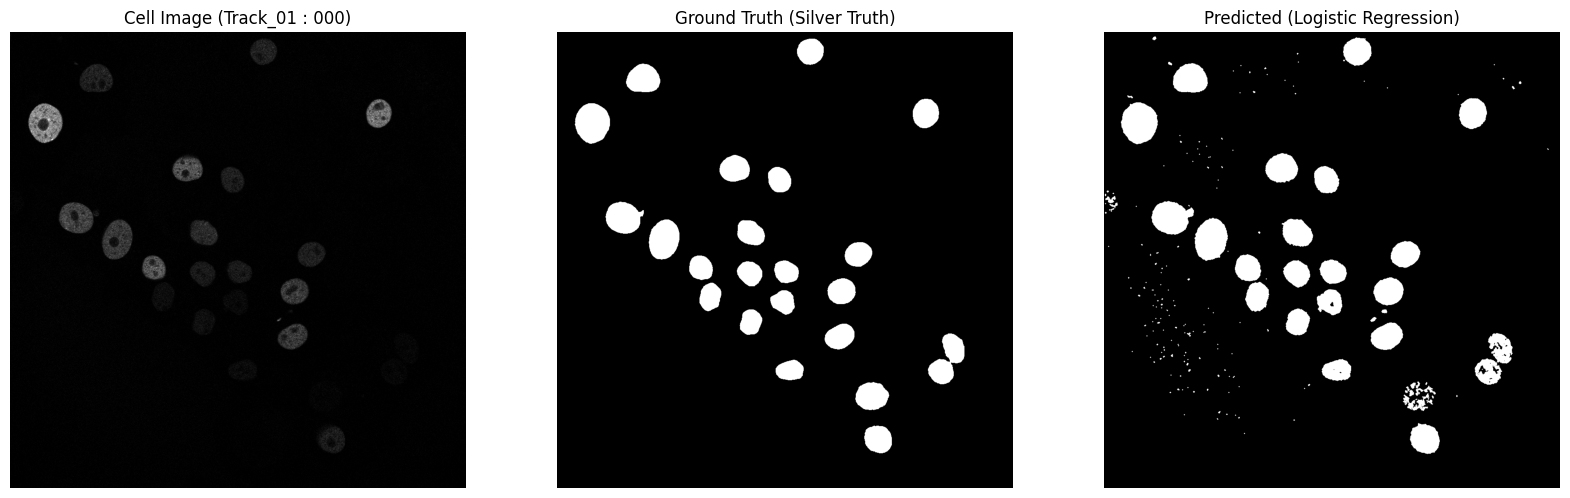

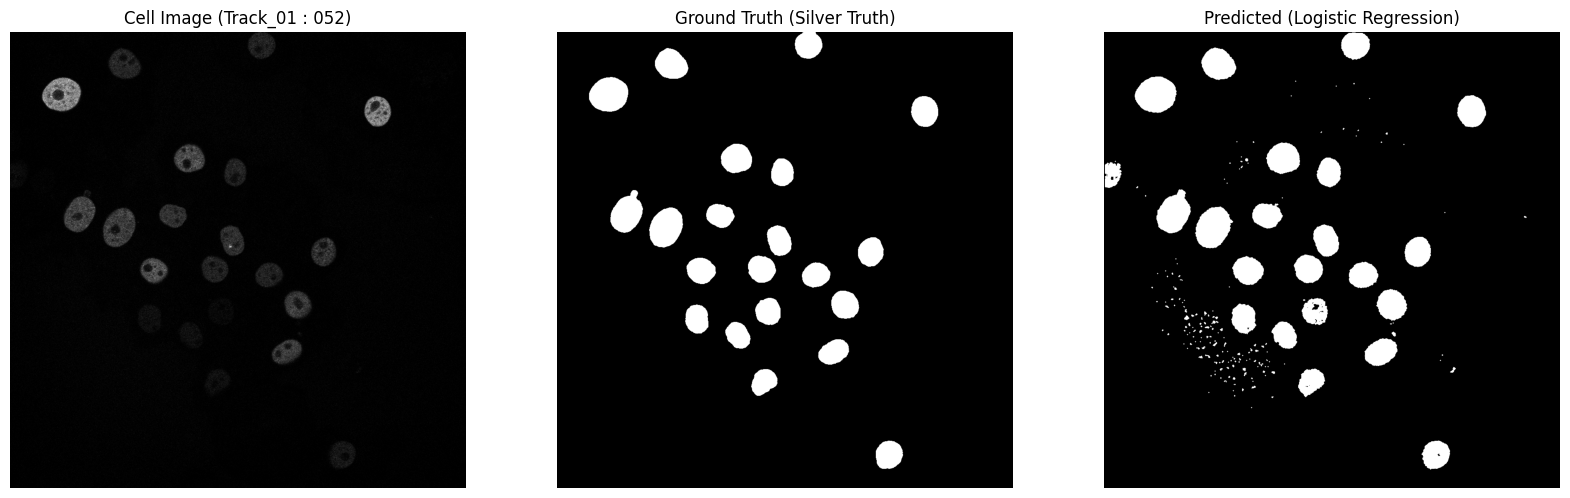

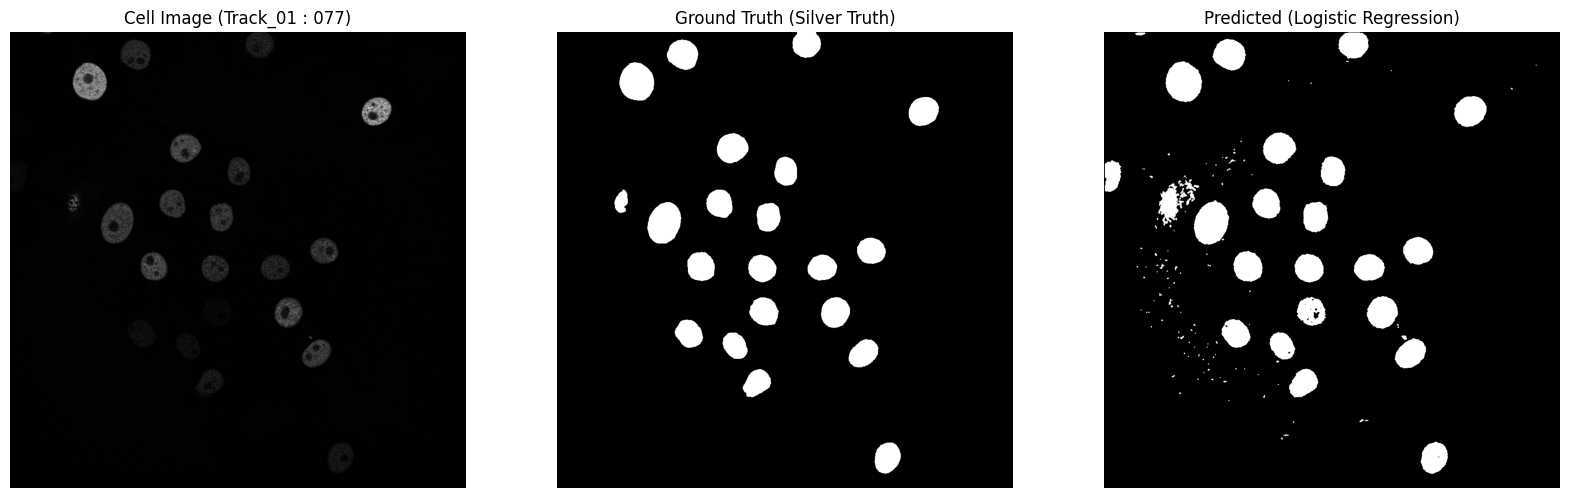

In [10]:
display_all_viz(img_num, '01', 'LOG')

# Visual Evaluation for Support Vector Machine (Linear Kernel)

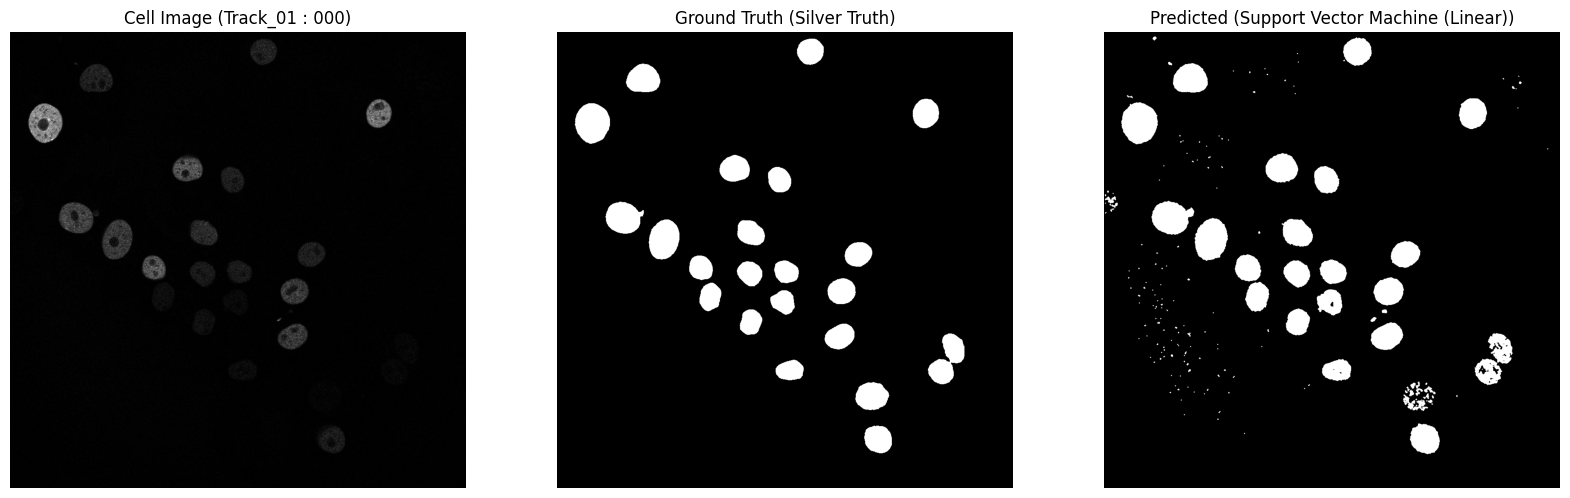

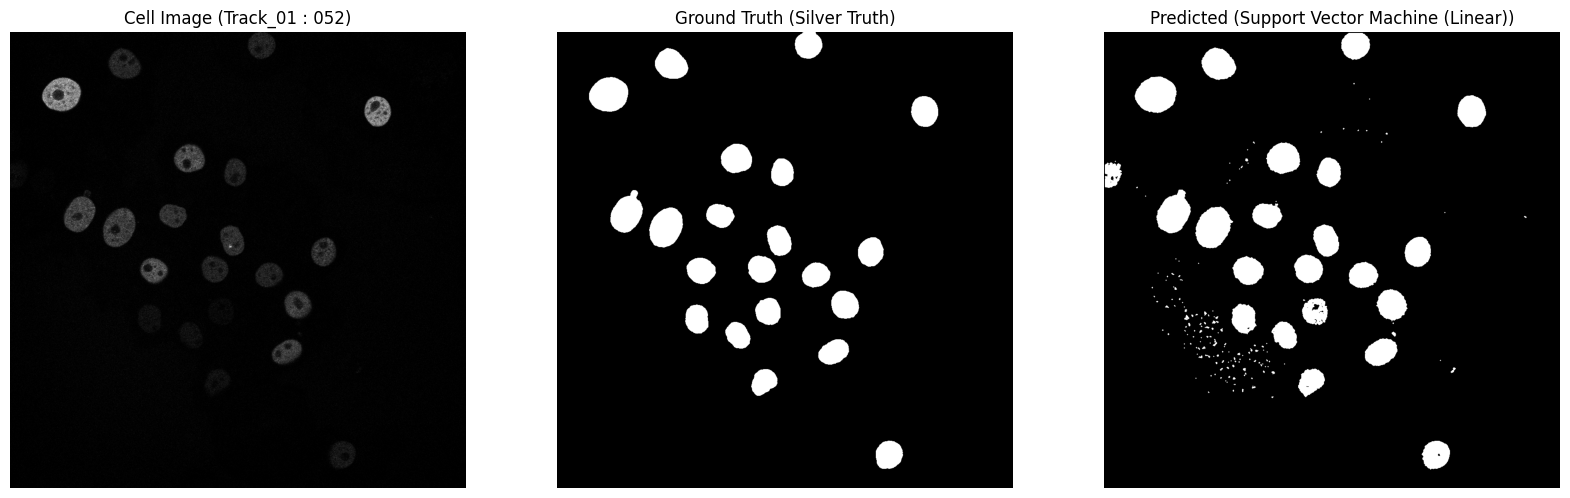

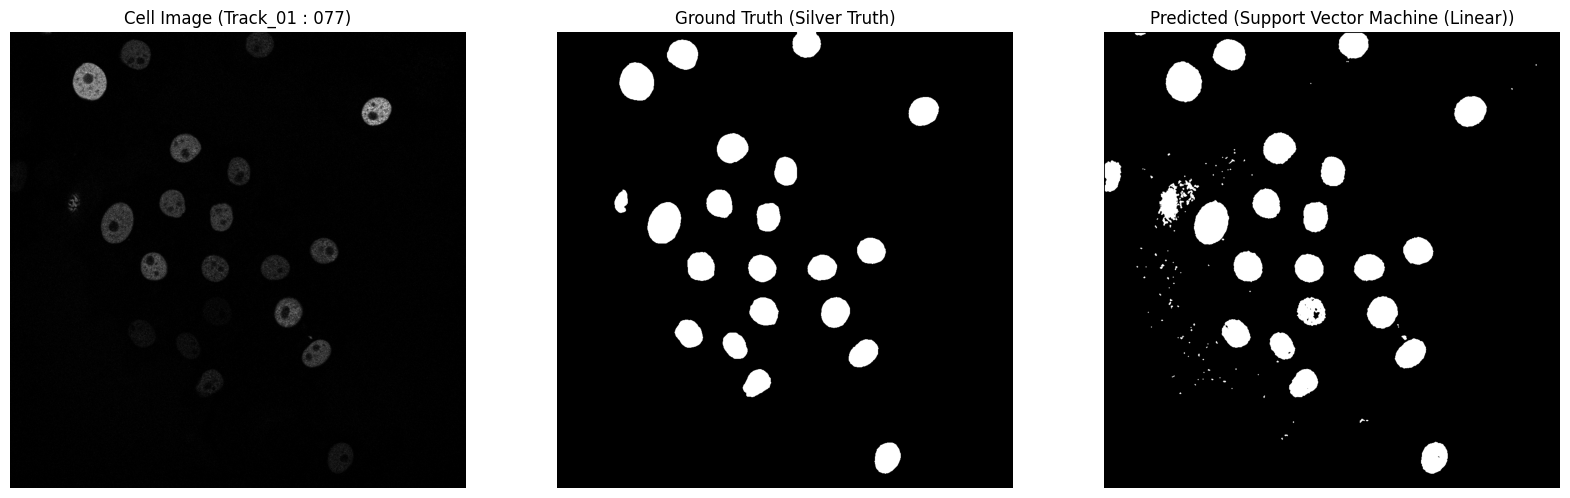

In [12]:
display_all_viz(img_num, '01', 'SVC_L')

# Visual Evaluation for Support Vector Machine (RBF Kernel)

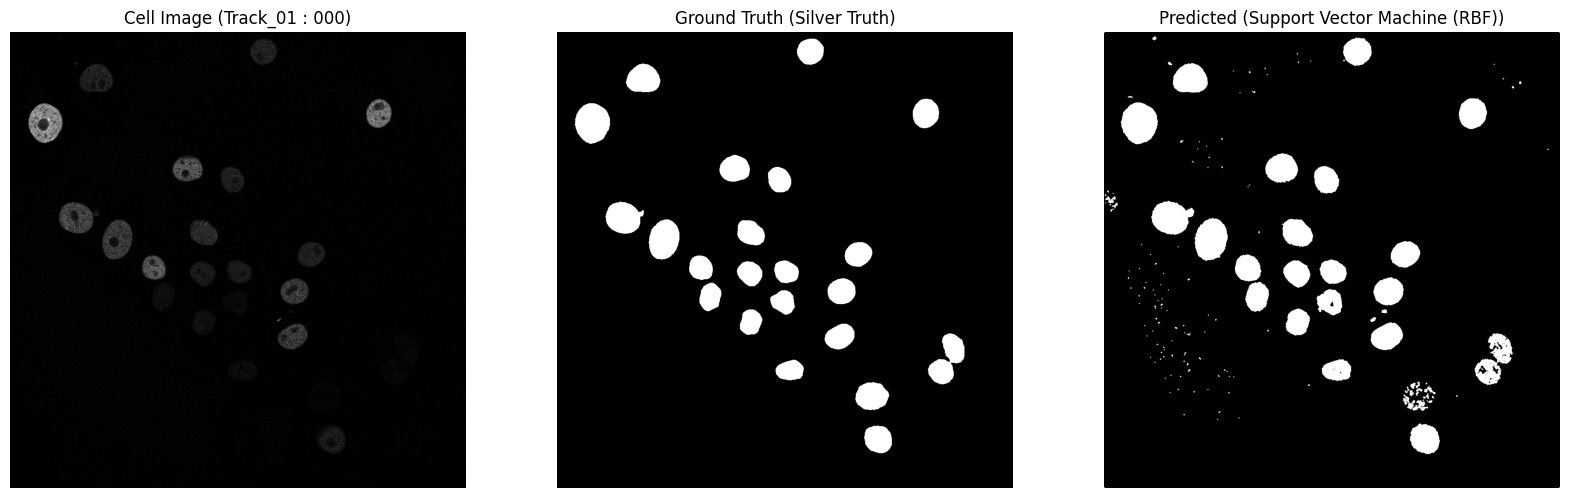

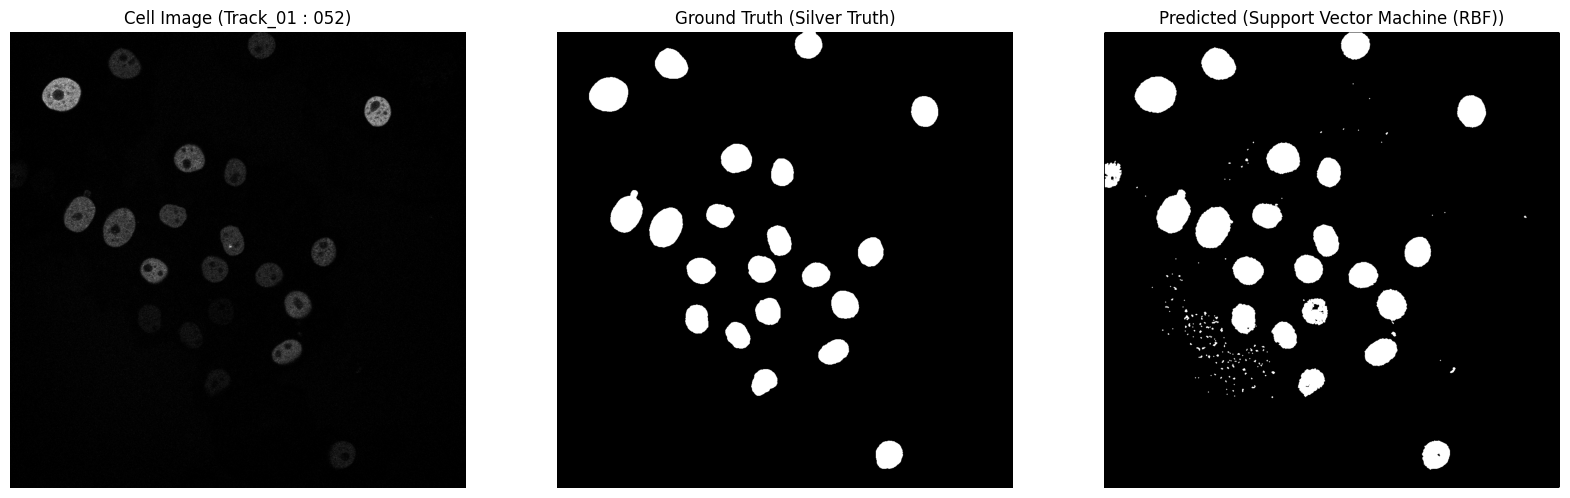

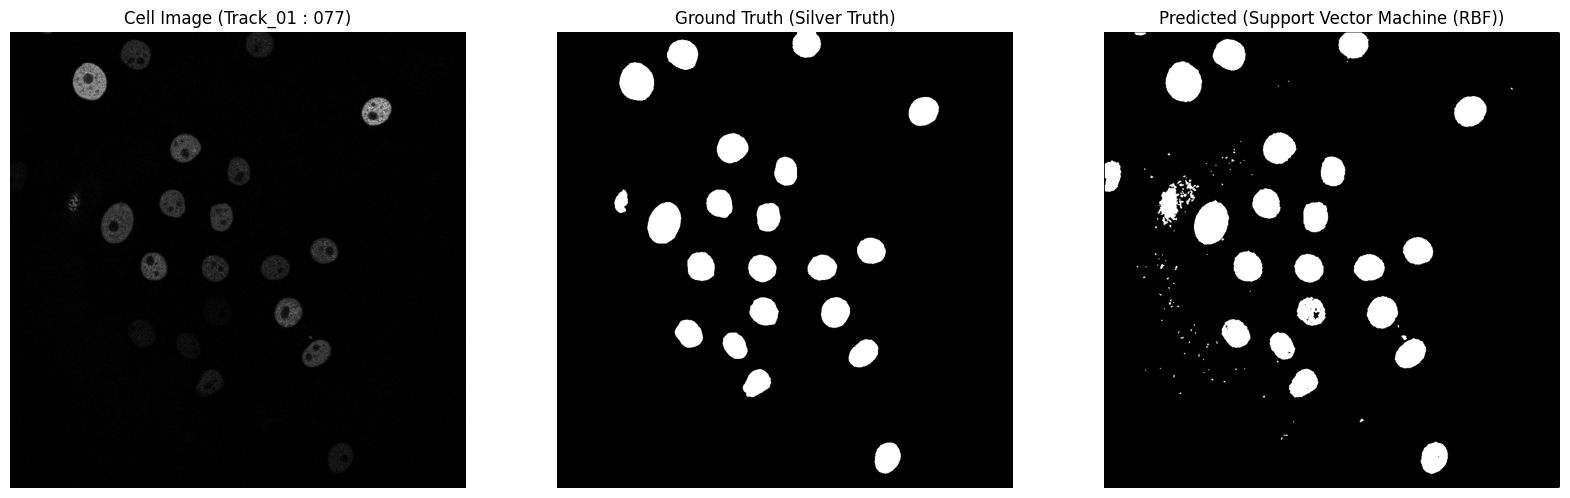

In [15]:
display_all_viz(img_num, '01', 'SVC_R')

# Visual Evaluation for Naive Bayes

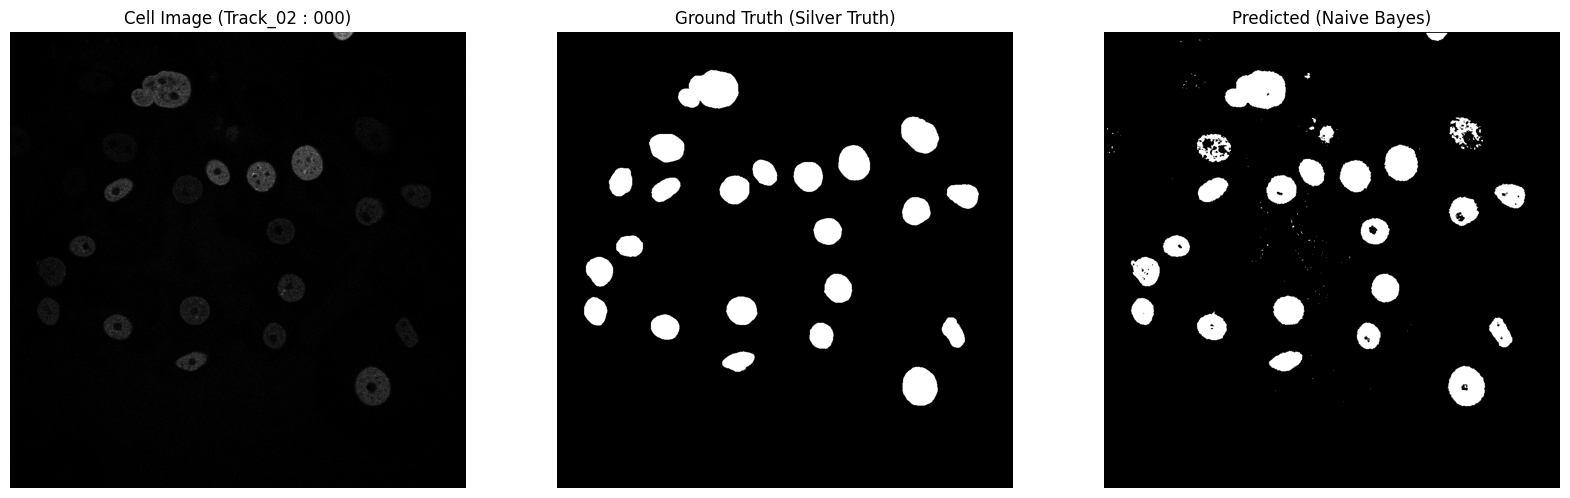

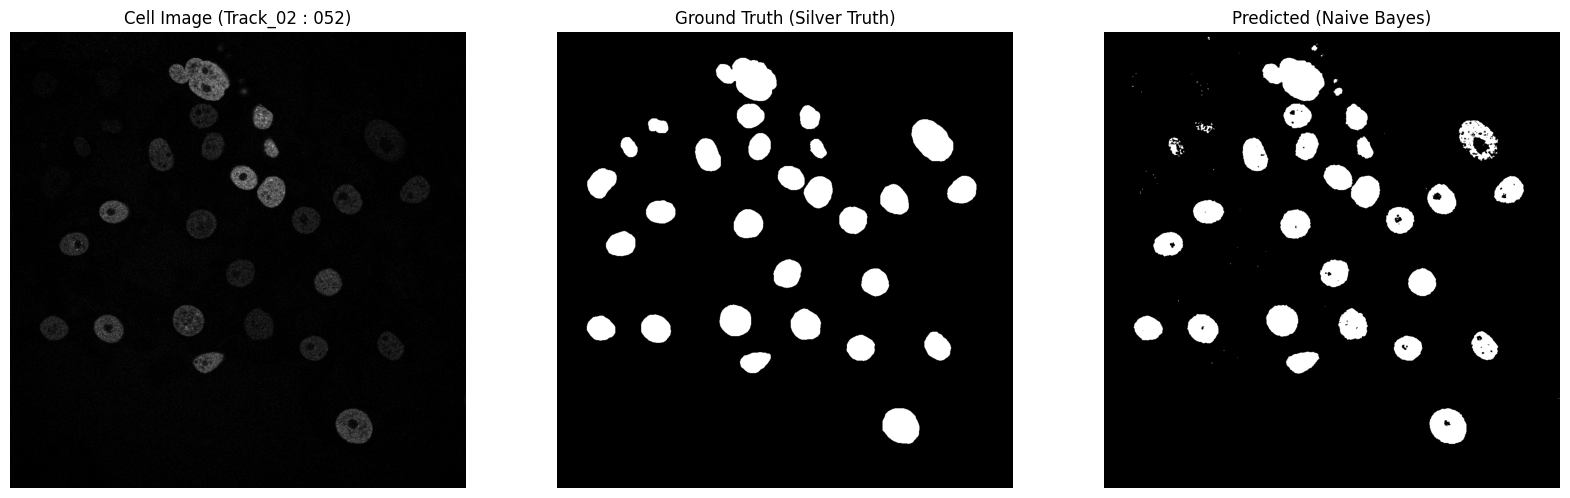

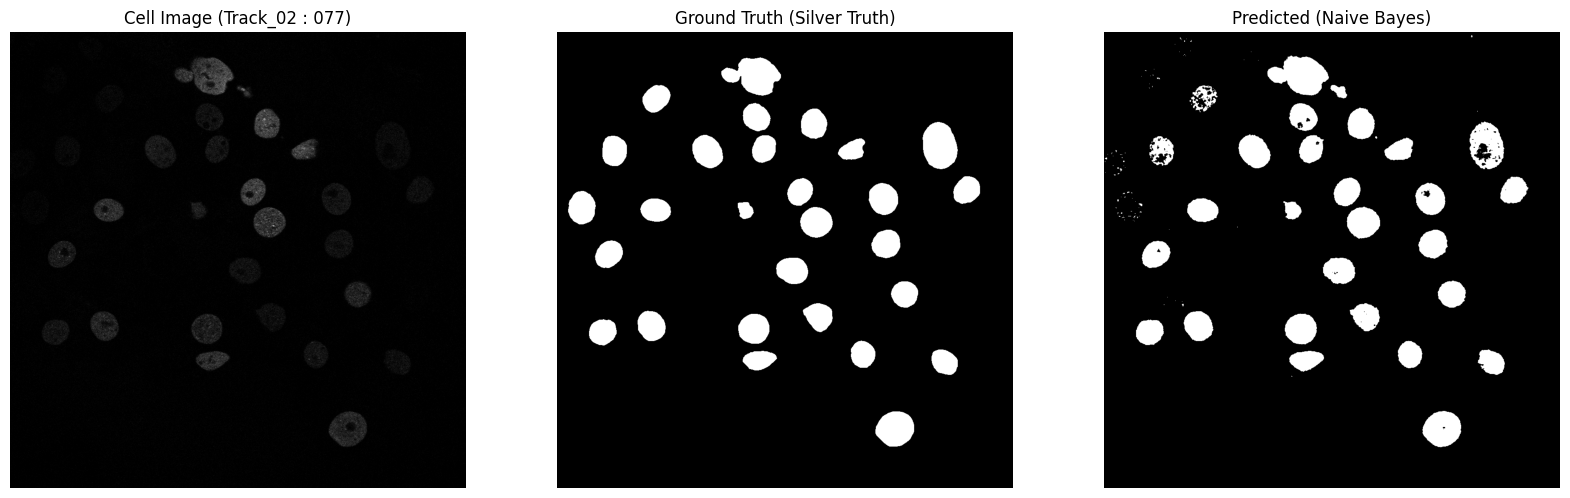

In [14]:
display_all_viz(img_num, '02', 'N_BAYES')

# SVC (Linear)

In [42]:
!python MySEGMeasure.py ./test-datasets/Fluo-N2DH-GOWT1/01_GT/SEG/ ./test-datasets/Fluo-N2DH-GOWT1/01_SVC_L

Mean Jaccard Index: 0.8839607462776901


In [43]:
!python MySEGMeasure.py ./test-datasets/Fluo-N2DH-GOWT1/02_GT/SEG/ ./test-datasets/Fluo-N2DH-GOWT1/02_SVC_L

Mean Jaccard Index: 0.8492084979161795


# SVC (RBF)

In [183]:
!python MySEGMeasure.py ./test-datasets/Fluo-N2DH-GOWT1/01_GT/SEG/ ./test-datasets/Fluo-N2DH-GOWT1/01_SVC_R

Mean Jaccard Index: 0.8684476448863024


In [184]:
!python MySEGMeasure.py ./test-datasets/Fluo-N2DH-GOWT1/02_GT/SEG/ ./test-datasets/Fluo-N2DH-GOWT1/02_SVC_R

Mean Jaccard Index: 0.8491180567665881


# Naive Bayes

In [165]:
!python MySEGMeasure.py ./test-datasets/Fluo-N2DH-GOWT1/01_GT/SEG/ ./test-datasets/Fluo-N2DH-GOWT1/01_N_BAYES/

Mean Jaccard Index: 0.8683750660372966


In [166]:
!python MySEGMeasure.py ./test-datasets/Fluo-N2DH-GOWT1/02_GT/SEG/ ./test-datasets/Fluo-N2DH-GOWT1/02_N_BAYES/

Mean Jaccard Index: 0.8329306710929285


# Logistic Regression

In [46]:
!python MySEGMeasure.py ./test-datasets/Fluo-N2DH-GOWT1/01_GT/SEG/ ./test-datasets/Fluo-N2DH-GOWT1/01_LOG/

Mean Jaccard Index: 0.882416528135413


In [47]:
!python MySEGMeasure.py ./test-datasets/Fluo-N2DH-GOWT1/02_GT/SEG/ ./test-datasets/Fluo-N2DH-GOWT1/02_LOG/

Mean Jaccard Index: 0.8477494360469903


# Results Table (Go to [TOP](#top))
<a id='results'></a>

In [48]:
import pandas as pd
import numpy as np

# Define methods as columns -- customize if you add more
methods = ['Naive Bayes', 'LogReg', 'SVM(Linear)', 'SVM(RbF)']

# Define the variations heirarchically -- customize if you want to
# add other variations or other datasets from the contest site
datasets = {
    'Fluo-N2DH-GOWT1': {
        'ST': {'01', '02'}
    }
}

# Creating MultiIndex for rows
rows = []
for dataset, subsets in datasets.items():
    for subset, tracks in subsets.items():
        for track in tracks:
            rows.append((dataset, subset, track))

# Creating the DataFrame
multi_index = pd.MultiIndex.from_tuples(rows, names=['Dataset', 'Truth', 'Track'])
df = pd.DataFrame(index=multi_index, columns=methods).astype(float)

In [64]:
# Set the mIoU score for an experiment
df.loc[('Fluo-N2DH-GOWT1', 'ST', '01'), 'SVM(Linear)'] = 0.884
df.loc[('Fluo-N2DH-GOWT1', 'ST', '02'), 'SVM(Linear)'] = 0.850

df.loc[('Fluo-N2DH-GOWT1', 'ST', '01'), 'SVM(RbF)'] = 0.870
df.loc[('Fluo-N2DH-GOWT1', 'ST', '02'), 'SVM(RbF)'] = 0.850


df.loc[('Fluo-N2DH-GOWT1', 'ST', '01'), 'LogReg'] = 0.883
df.loc[('Fluo-N2DH-GOWT1', 'ST', '02'), 'LogReg'] = 0.850


df.loc[('Fluo-N2DH-GOWT1', 'ST', '01'), 'Naive Bayes'] = 0.863
df.loc[('Fluo-N2DH-GOWT1', 'ST', '02'), 'Naive Bayes'] = 0.83
# Display the updated DataFrame
display(df)

Naive Bayes  LogReg  SVM(Linear)  SVM(RbF)
Dataset         Truth Track                                            
Fluo-N2DH-GOWT1 ST    02           0.830   0.850        0.850      0.85
                      01           0.863   0.883        0.884      0.87